LGBMをOptunaでチューニング... 
fExp上位(=fImp上位)のFeatureを順に削っていき順次モデル作成  
各modelの比較を行う. 分析の切り口は featureImportance, featureExposure, predictionの相関,sharpe,DD等 


In [1]:
import seaborn as sns
import csv
import optuna
import optuna.integration.lightgbm as lgb
import itertools, logging, joblib
import networkx as nx
NOTE_NAME = "lgbm2"

In [2]:
ROUND = "237"
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"
N_FEATURE = 310

In [3]:
# Load Dataset
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)
    return df

train = read_csv("../../dataset/numerai_dataset_237/numerai_training_data.csv")
tournament = read_csv("../../dataset/numerai_dataset_237/numerai_tournament_data.csv")

# reform
train.sort_index(axis=1, inplace=True)
tournament.sort_index(axis=1, inplace=True)
cols_feature = train.columns[train.columns.str.contains("feature_")]
cols_target  = train.columns[train.columns.str.contains("target_")]

In [4]:
train.head(1).append(tournament.tail(1))

,data_type,era,feature_charisma1,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma2,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma3,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma4,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma5,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma6,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma7,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma8,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_charisma9,feature_constitution1,feature_constitution10,feature_constitution100,feature_constitution101,feature_constitution102,feature_constitution103,feature_constitution104,feature_constitution105,feature_constitution106,feature_constitution107,feature_constitution108,feature_constitution109,feature_constitution11,feature_constitution110,feature_constitution111,feature_constitution112,feature_constitution113,feature_constitution114,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution2,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution3,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution4,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_constitution49,feature_constitution5,feature_constitution50,feature_constitution51,feature_constitution52,feature_constitution53,feature_constitution54,feature_constitution55,feature_constitution56,feature_constitution57,feature_constitution58,feature_constitution59,feature_constitution6,feature_constitution60,feature_constitution61,feature_constitution62,feature_constitution63,feature_constitution64,feature_constitution65,feature_constitution66,feature_constitution67,feature_constitution68,feature_constitution69,feature_constitution7,feature_constitution70,feature_constitution71,feature_constitution72,feature_constitution73,feature_constitution74,feature_constitution75,feature_constitution76,feature_constitution77,feature_constitution78,feature_constitution79,feature_constitution8,feature_constitution80,feature_constitution81,feature_constitution82,feature_constitution83,feature_constitution84,feature_constitution85,feature_constitution86,feature_constitution87,feature_constitution88,feature

In [5]:
from scipy.stats import spearmanr
def calcFeatureExposure(X:pd.DataFrame, pred:np.ndarray)->pd.Series:
    # pred: np.array
    exposures = [spearmanr(pred, X[col])[0] for col in X.columns]
    return pd.Series(exposures, index=X.columns)

In [6]:
model = {i: joblib.load(f"{NOTE_NAME}/best_model_{i}.pkl") for i in range(0,6)}

In [7]:
[len(m.feature_name()) for m in model.values()]

[310, 279, 251, 225, 202, 181]

-----  
## 各モデルのFeatureImportance, FeatureExposure

In [ ]:
# featureExpとfeatureImpを各Featureについて計算
feature_info = []
for m in model.values():
    f = pd.concat(
        [pd.Series(m.feature_importance(), index=m.feature_name()).to_frame(f"fi"),
         calcFeatureExposure(train.loc[:, m.feature_name()], m.predict(train.loc[:, m.feature_name()])).to_frame(f"fe")], axis=1)
    f["feature_category"] = f.index.str.replace("[0-9]","").str.replace("feature_","")
    feature_info.append(f)

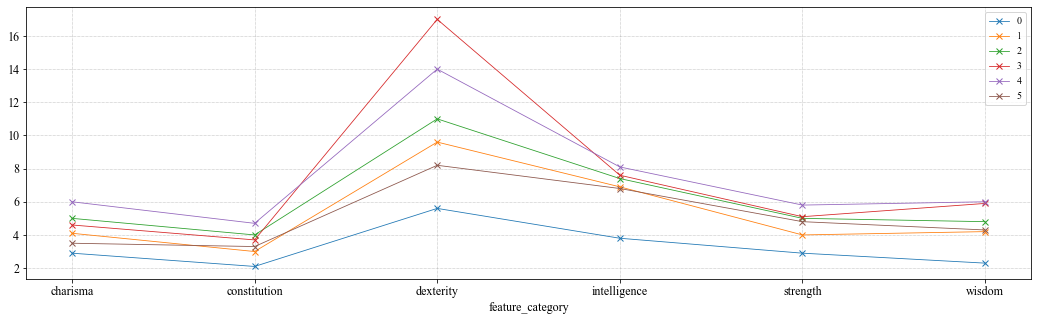

In [94]:
# 各モデルの category別 平均 feature importance 
pd.concat([f.groupby("feature_category").fi.mean().to_frame(i) for i,f in enumerate(feature_info)], axis=1)\
    .round(1).plot(figsize=(18,5), marker="x")

カテゴリ別のfImp傾向は基本的にはあまり変わらない...

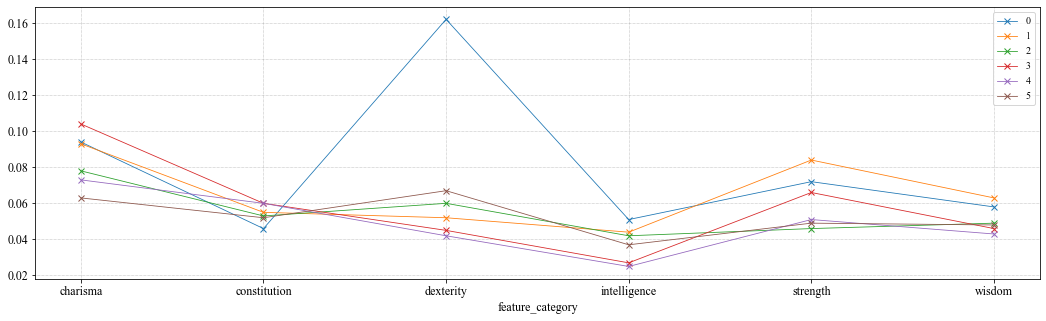

In [93]:
# 各モデルの カテゴリ別 平均 feature exposure
pd.concat([f.fe.abs().groupby(f.feature_category).mean().to_frame(i) for i,f in enumerate(feature_info)], axis=1)\
    .round(3).plot(figsize=(18,5), marker="x")

fExpで見るとカテゴリ別平均はちゃんとばらけている印象  
とはいえカテゴリ間の大小関係は概ね保存されてしまっている...?

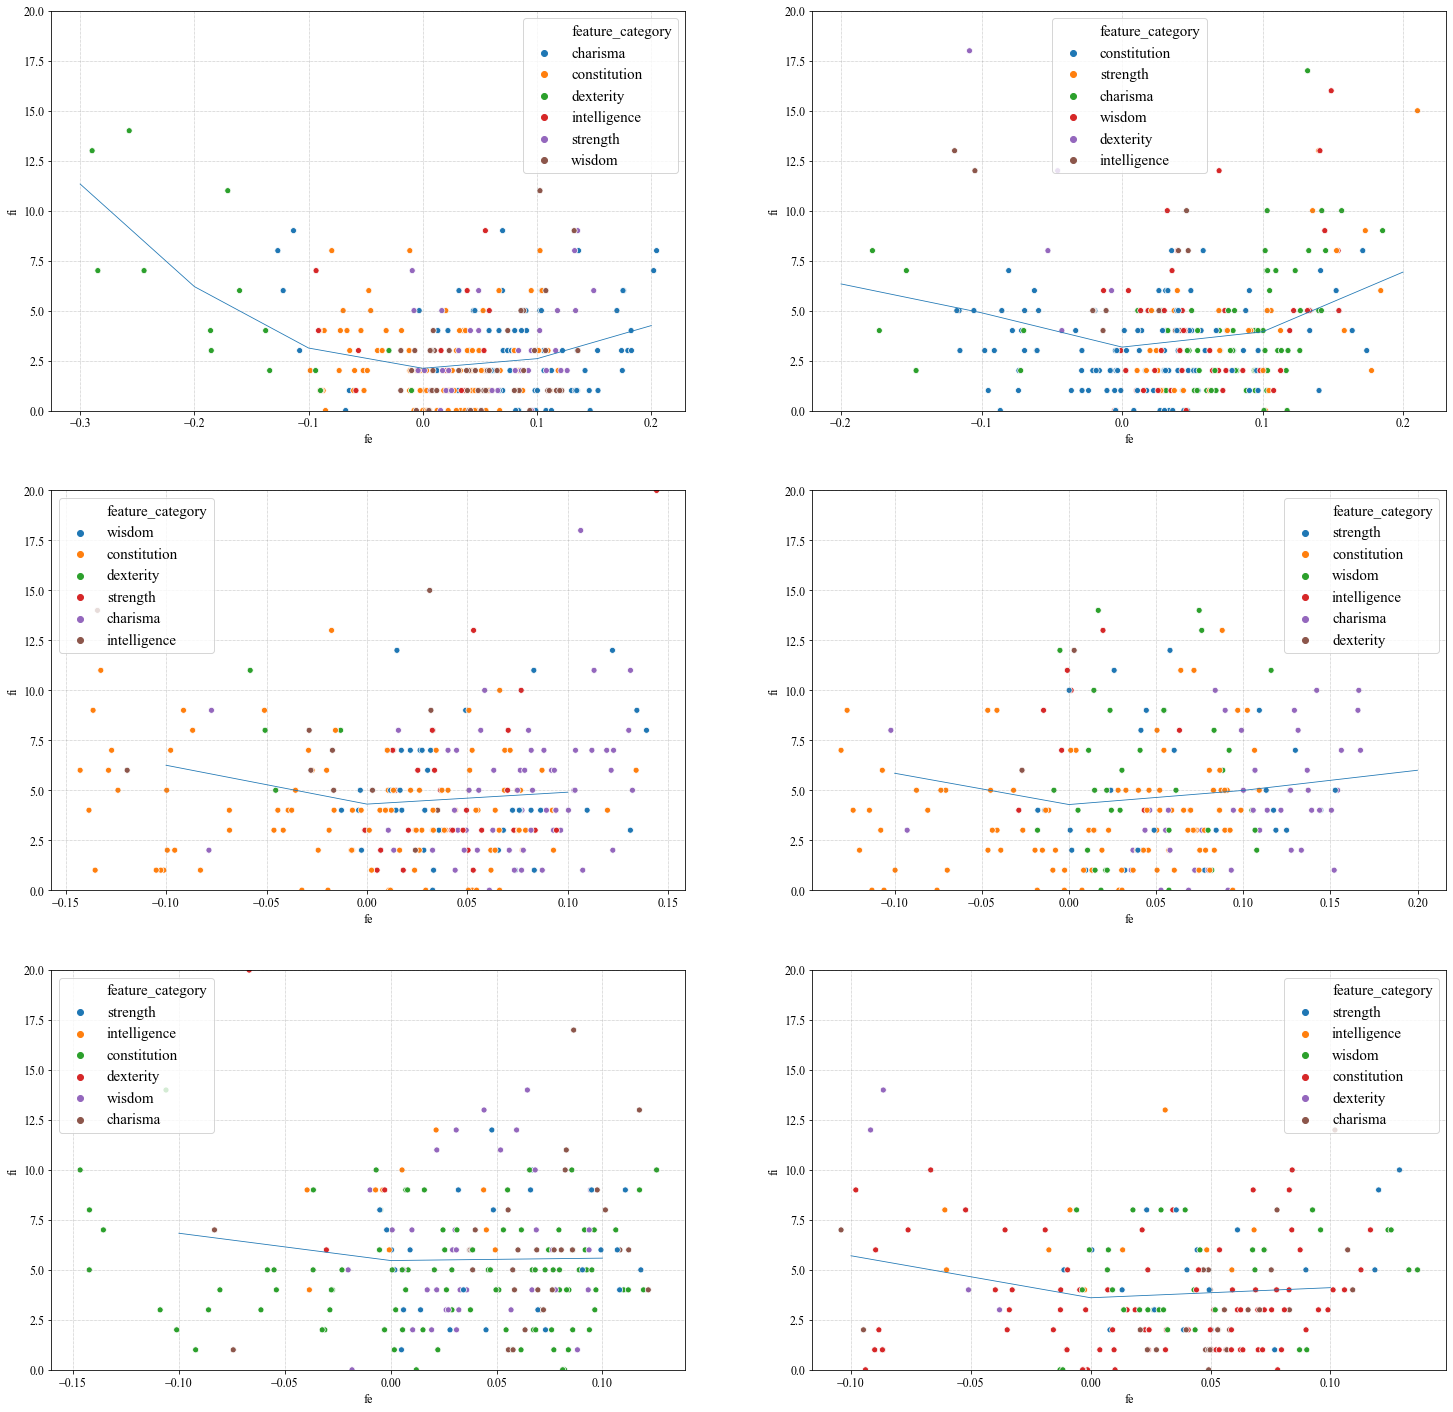

In [86]:
# 各モデル fExp vs. fImp
fig,ax = plt.subplots(3,2, figsize=(25,25)); ax = ax.flatten();
for i,f in enumerate(feature_info):
    sns.scatterplot(x="fe", y="fi", data=f, hue="feature_category", ax=ax[i]);
    sns.lineplot(y="fi", x="fe", data=f[["fi"]].groupby(f.fe.round(1)).fi.mean().reset_index(), ax=ax[i])
    ax[i].legend(fontsize=(15));
    ax[i].set_ylim(0, 20);

model2以降は fExp大 => fImp大 傾向は緩和されているように見える. fExpが高いからといってfImpが高いわけではない.  
分割に使われていなくてもfExpは高くなりうる. 


----  
## outputの比較

In [8]:
# signal
signals = pd.concat(
    [pd.Series(m.predict(train.loc[:, m.feature_name()]), index=train.index, name=i) for i,m in model.items()], axis=1)
signals = signals.join(train.era).join(train[TARGET_NAME])
signals["eraNum"] = signals.era.str.slice(3).astype(int)

val_signals = pd.concat(
    [pd.Series(m.predict(tournament.loc[:, m.feature_name()]), index=tournament.index, name=i) for i,m in model.items()], axis=1)
val_signals = val_signals.join(tournament.era).join(tournament[TARGET_NAME]).dropna()
val_signals["eraNum"] = val_signals.era.str.slice(3).astype(int)

In [66]:
# signals.to_csv(f"{NOTE_NAME}/lgbm2_signals_train.csv")
# val_signals.to_csv(f"{NOTE_NAME}/lgbm2_signals_val.csv")

In [65]:
signals

,0,1,2,3,4,5,era,target_kazutsugi,eraNum
id,,,,,,,,,
n000315175b67977,0.480082,0.497053,0.490263,0.495587,0.501191,0.495600,era1,0.75,1
n0014af834a96cdd,0.500495,0.493641,0.499029,0.490634,0.494754,0.503093,era1,0.25,1
n001c93979ac41d4,0.489105,0.490004,0.504203,0.509176,0.500028,0.494497,era1,0.00,1
n0034e4143f22a13,0.504036,0.503082,0.505008,0.505892,0.495922,0.508459,era1,0.00,1
n00679d1a636062f,0.491466,0.496042,0.494283,0.481790,0.487717,0.492017,era1,0.75,1
...,...,...,...,...,...,...,...,...,...
nff6a8a8feaeeb52,0.501623,0.491661,0.494385,0.478263,0.485632,0.493971,era120,0.25,120
nff6af62a0996372,0.529458,0.524138,0.522428,0.513729,0.513182,0.506489,era120,1.00,120
nff9288983b8c040,0.500316,0.489241,0.495521,0.521176,0.511473,0.506883,era120,0.00,120


In [10]:
signals.head(1)

,0,1,2,3,4,5,era,target_kazutsugi,eraNum
id,,,,,,,,,
n000315175b67977,0.480082,0.497053,0.490263,0.495587,0.501191,0.4956,era1,0.75,1


---  
signal間 correlation(pearson)

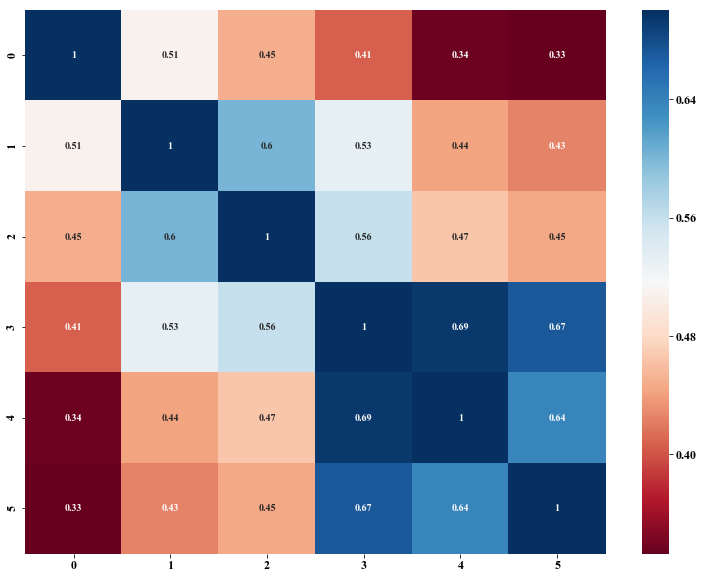

In [45]:
# 相関行列
plt.figure(figsize=(13, 10))
corrMat = signals.iloc[:, :6].corr()
sns.heatmap(corrMat, annot=True, cmap="RdBu", vmax=0.7);

model iと model i+1は出力が似ている傾向.

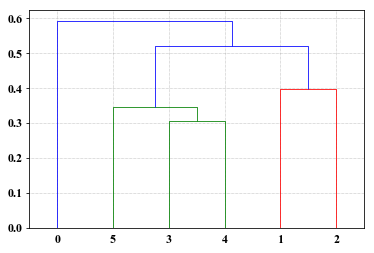

In [68]:
# 相関でデンドログラム
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.spatial.distance as distance
dArray = distance.squareform(1-corrMat.values)
link = linkage(dArray, method='average')
dendrogram(link);

区分けするとすると, (0,), (1,2), (3,4, 5) といった感じ

---  
model別 CORR score

In [80]:
# Submissions are scored by spearman correlation
def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [52]:
# era毎にcorr計算
corr = pd.concat([signals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(6)], axis=1)
val_corr = pd.concat([val_signals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(6)], axis=1)

In [53]:
# in sample score
corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,0.103385,0.107082,0.116351,0.089380,0.109941,0.091102
std,0.033152,0.026694,0.023032,0.025318,0.024286,0.023096
<lambda>,3.118547,4.011519,5.051722,3.530336,4.526873,3.944447


In [54]:
# validation sample score
val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,0.027824,0.025530,0.022283,0.025300,0.021888,0.025592
std,0.030078,0.025659,0.023283,0.022786,0.017836,0.020288
<lambda>,0.925042,0.994942,0.957046,1.110335,1.227173,1.261481


validation sharpeは後続モデルの方が優れている

In [75]:
# sample model
val_signals.join(example_preds).groupby("eraNum").apply(calcRankCorr(PREDICTION_NAME)).agg(["mean", "std", lambda x: x.mean()/x.std()]).to_frame()

,0
mean,0.028878
std,0.030828
<lambda>,0.936728


---  
Neutralize後のモデル別 CORR score

In [31]:
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()

def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [43]:
# neutralized signals
nSignals = pd.concat([neutralize(train.join(signals[[i]]).dropna(), [i], cols_feature) for i in range(6)], axis=1)
nSignals = nSignals.join(train.era).join(train[TARGET_NAME])
nSignals["eraNum"] = nSignals.era.str.slice(3).astype(int)

val_nSignals = pd.concat([neutralize(tournament.join(val_signals[[i]]).dropna(), [i], cols_feature) for i in range(6)], axis=1)
val_nSignals = val_nSignals.join(tournament.era).join(tournament[TARGET_NAME])
val_nSignals["eraNum"] = val_nSignals.era.str.slice(3).astype(int)

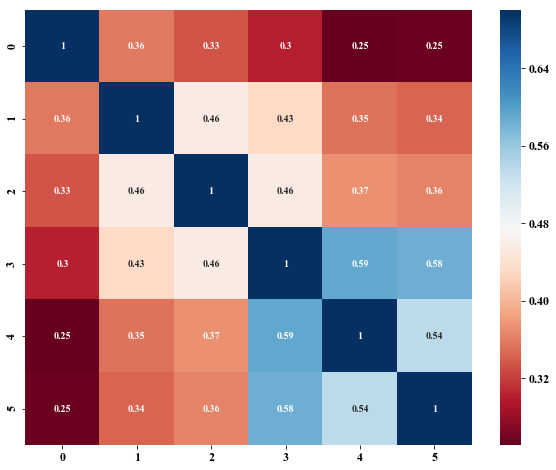

In [28]:
# 相関行列
plt.figure(figsize=(10, 8))
corrMat = nSignals.iloc[:, :6].corr()
sns.heatmap(corrMat, annot=True, cmap="RdBu", vmax=0.7);

neutralizeするとmodel間の相関が下がる

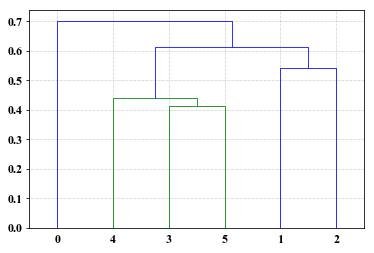

In [44]:
# 相関でデンドログラム
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.spatial.distance as distance
dArray = distance.squareform(1-nSignals.iloc[:,:6].corr().values)
link = linkage(dArray, method='average')
dendrogram(link);

とはいえmodel間の関係はneutralize後も保存される

In [46]:
# era毎にneutralized_corr計算
neutralized_corr = pd.concat([nSignals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(6)], axis=1)
val_neutralized_corr = pd.concat([val_nSignals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(6)], axis=1)

**Training sample**

In [60]:
neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,0.095664,0.106086,0.115450,0.086744,0.108231,0.087686
std,0.018055,0.020077,0.018018,0.021243,0.021021,0.020076
<lambda>,5.298443,5.283979,6.407487,4.083431,5.148762,4.367749


In [58]:
neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]) - corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,-0.007721,-0.000997,-0.000901,-0.002636,-0.001710,-0.003416
std,-0.015097,-0.006617,-0.005014,-0.004075,-0.003265,-0.003020
<lambda>,2.179897,1.272460,1.355765,0.553095,0.621889,0.423302


**Valiation sample**

In [59]:
val_neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])  # neutralized

,0,1,2,3,4,5
mean,0.021690,0.020719,0.022017,0.023525,0.019094,0.023441
std,0.018913,0.019299,0.018899,0.022440,0.016591,0.020207
<lambda>,1.146836,1.073549,1.165002,1.048339,1.150898,1.160045


In [57]:
val_neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]) - val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,-0.006133,-0.004811,-0.000266,-0.001775,-0.002794,-0.002151
std,-0.011165,-0.006360,-0.004384,-0.000346,-0.001245,-0.000080
<lambda>,0.221794,0.078607,0.207956,-0.061996,-0.076276,-0.101436


meanとstdの両方が下がる.  
もともと性能の高かったmodel3,4,5についてはsharpeが逆に下がってしまっている.  
これらのmodelではstdの減少が小さい

---  
MMC (validationのみ)

In [69]:
example_preds = \
    pd.read_csv(f"../../dataset/numerai_dataset_237/example_predictions_target_kazutsugi.csv")\
    .set_index("id").loc[tournament.index]

In [167]:
val_signals = example_preds.join(val_signals).dropna()

In [194]:
# MMC over validation
def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized

corrs = pd.DataFrame(); mmcs = pd.DataFrame()
for model_id in range(6):
    mmc_scores = []
    corr_scores = []
    for _, x in val_signals.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[model_id])), pd.Series(unif(x[PREDICTION_NAME])))
        mmc_scores.append( np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2) )
        corr_scores.append( correlation(unif(x[model_id]), x[TARGET_NAME]) )
    mmcs.loc[:, model_id] = mmc_scores
    corrs.loc[:, model_id] = corr_scores

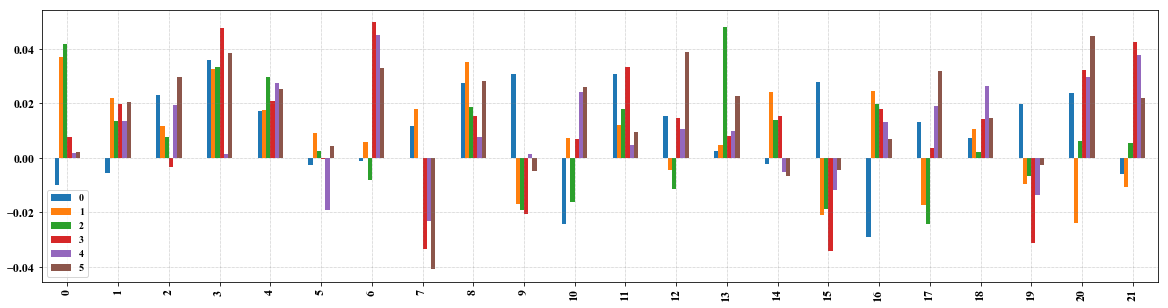

In [200]:
mmcs.plot.bar(figsize=(20, 5));

In [202]:
mmcs.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,0.009403,0.007682,0.007124,0.010327,0.010000,0.015425
std,0.017986,0.018406,0.019925,0.024233,0.018026,0.020055
<lambda>,0.522789,0.417354,0.357530,0.426172,0.554763,0.769155


mmcは1%程度. model5が最もパフォーマンス良い.

In [206]:
(mmcs+corrs).agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5
mean,0.037227,0.033212,0.029406,0.035627,0.031888,0.041017
std,0.045077,0.039530,0.039318,0.042743,0.032216,0.037575
<lambda>,0.825847,0.840169,0.747916,0.833515,0.989835,1.091626


CORR + MMCでもmodel5が強い